In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator
import matplotlib.patheffects as pe
import numpy as np
import copy
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.config import read_config

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

### Read data

In [10]:
pgrid_dir = "data/scratch/l98d_habrok5/"
cases = lg.get_cases(pgrid_dir, only_completed=True)
ncases = len(cases)

In [22]:
cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 237/237 [00:03<00:00, 68.22it/s]


Done


In [23]:
solid_thresh = float(lg.descend_get(conf[0],"params.stop.solid.phi_crit"))*1.01
print("Solidification threshold = %.3f%%"%(solid_thresh*100))

Solidification threshold = 0.505%


In [24]:
# %matplotlib widget

%matplotlib inline
# %config InlineBackend.figure_format='retina'

### Function to plot z vs x,y scatter graphs

In [29]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control,
             title="",
             figscale=1.0, figsize=(5.0,4.0),
             show_cbar=True, annotate="", cmap=cm.batlow,
             plot_scatter=True, plot_casenums=False, plot_controls=False, idx=-1,
             xscale="linear", xmult=1.0, xmajor=None, xminor=None,
             yscale="linear",ymult=1.0, ymajor=None, yminor=None,
             fmt_cbar="%g", marker_s = 100, plot_grid=False,
             zscale="linear", zmult=1.0, minz=None, maxz=None, ztruth=None, truth_lbl="Truth", zflip=False,
             norm_lev = 11, interp='none', hatch_solid=False, symmetric=False, extend='both'):

    # Plotting parameters
    marker_e = 'none'   # scatter edge color
    hatch_c  = 'white'  # hatch color
    hatch_t  = '//'      # hatch type
    hatch_w  = 1.0      # hatch line width
    plot_leg = False
    boxalpha = 0.7
    fontsize = 10

    # Check params
    if symmetric and (zscale == "log"):
        print("WARNING: Cannot do symmetric colour-mapping with log-norm")
        return

    # Gather the data
    print("Gather data")
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable
    z_plt = np.array([], dtype=float) # z variable
    h_plt = np.array([], dtype=float) # hatch variable (i.e. melt fraction)
    c_plt = np.array([], dtype=str)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    for i in range(ncases):
        keep_this = True
        for k in control.keys():
            if not (lg.descend_get(conf[i],k) == control[k]):
                keep_this = False
        if not keep_this:
            continue

        cn = cnums[i]

        # duplicates?
        this_x =  lg.descend_get(conf[i],x)
        this_y = lg.descend_get(conf[i],y)
        for j in range(len(x_plt)):
            if np.isclose(this_x, x_plt[j]) and np.isclose(this_y, y_plt[j]):
                print("WARNING: Duplicate point added to array (case=%s, x=%g, y=%g)"%(cn, this_x, this_y))

        # get data
        if z == "RF_radius":
            this_z = 1-lg.access_hvars(hvars, "RF_depth", idx)[i]
        else:
            this_z = lg.access_hvars(hvars, z, idx)[i]

        # add point
        x_plt = np.append(x_plt, xmult*this_x)
        y_plt = np.append(y_plt, ymult*this_y)
        z_plt = np.append(z_plt, zmult*this_z)
        h_plt = np.append(h_plt, lg.access_hvars(hvars, "Phi_global", idx)[i])
        c_plt = np.append(c_plt, cn)
        g_plt = np.append(g_plt, bool( 10 <= stts[cn] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return
    b_plt = np.invert(g_plt)

    print("shape x:",np.shape(x_plt))
    print("shape y:",np.shape(y_plt))
    print("shape z:",np.shape(z_plt))

    print("max z:",np.amax(z_plt))
    print("med z:",np.median(z_plt))
    print("rg2 z:",0.5*(np.amax(z_plt) - np.amin(z_plt)))
    print("rg+ z:",np.amax(z_plt) - np.median(z_plt))
    print("rg- z:",np.median(z_plt) - np.amin(z_plt))
    print("min z:",np.amin(z_plt))

    # Do interpolation on z-variable
    interp_npts = 50
    interp = interp.lower().strip()
    do_interp = interp in ['contour', 'mesh']
    if do_interp:
        print("Interpolate z")
        marker_e='white'

        _,_,xxi,yyi,zzi = lg.interp_2d(x_plt,y_plt,z_plt, interp_npts, method='linear')

    # Hatch solid cases (if allowing interpolation)
    hatch_solid = hatch_solid and do_interp
    if hatch_solid:
        print("Interpolate phi")
        _,_,_,_,hhi = lg.interp_2d(x_plt, y_plt,h_plt, interp_npts, method='linear')

    # Colour mapping
    if minz == None:
        minz = np.amin(z_plt)
    if maxz == None:
        maxz = np.amax(z_plt)
    if abs(minz-maxz) < 1.0e-20:
        print("ERROR: minz and maxz are the same")
        return
    if minz > maxz:
        minz, maxz = maxz, minz
    if (zscale == "linear"):
        if symmetric:
            maxz = max(maxz, abs(minz))
            minz = -1.0 * maxz
        norm = mpl.colors.Normalize(vmin=minz, vmax=maxz)
        levels = np.linspace(minz, maxz, norm_lev)
    else:
        norm = mpl.colors.LogNorm(vmin=minz, vmax=maxz)
        levels = norm_lev
        # levels = np.logspace(np.log10(minz), np.log10(maxz), norm_lev)

    if symmetric:
        _cmap = copy.deepcopy(cmap)
    else:
        _cmap = copy.deepcopy(cmap)
        _cmap.set_under('crimson')
        _cmap.set_over('slategrey')

    sm = plt.cm.ScalarMappable(cmap=_cmap, norm=norm)
    sm.set_array([])
    mappable = sm # mappable for colorbar

    # Make the plot
    print("Plot")
    fig,ax = plt.subplots(1,1, figsize=(figsize[0]*figscale,figsize[1]*figscale))

    #    plot interpolation
    if do_interp:
        zzi = np.clip(zzi, minz*(1+1.0e-10), maxz*(1-1.0e-10))  # avoid numerical artifacts from interpolation + cmapping
        match interp:
            case 'scatter':
                ax.scatter(xxi, yyi, c=zzi,  cmap=_cmap, norm=norm,)
            case 'contour':
                mappable = ax.contourf(xxi,yyi,zzi, cmap=_cmap, norm=norm, levels=levels, extend=extend)
            case 'mesh':
                ax.pcolormesh(xxi,yyi,zzi, cmap=_cmap, norm=norm)

    #    plot truth
    if (interp == 'contour') and (ztruth is not None):
        _lw = 2
        _lc = 'royalblue'
        _pe = [pe.withStroke(linewidth=_lw+1, foreground="k")]
        if len(ztruth) == 1:
            ztruth = ztruth[0]
            cnt = ax.contour(xxi,yyi,zzi, levels=(-1e99,ztruth,1e99), colors=(_lc,), linestyles='solid', linewidths=_lw, zorder=5)
            plt.setp(cnt, path_effects=_pe)
        else:
            for i,z in enumerate(ztruth):
                if i == 1:
                    _ls = 'solid'
                else:
                    _ls = 'dashed'
                cnt = ax.contour(xxi,yyi,zzi, levels=(-1e99,z,1e99), colors=(_lc,), linestyles=_ls, linewidths=_lw, zorder=5)
                plt.setp(cnt, path_effects=_pe)
        ax.plot([],[],ls='solid',lw=_lw,label=truth_lbl,color=_lc,path_effects=_pe)
        plot_leg = True

    #    plot hatches
    if hatch_solid:
        mpl.rcParams['hatch.linewidth'] = hatch_w
        mpl.rcParams['hatch.color'] = hatch_c
        if np.any(hhi <= solid_thresh):
            # contour hatches
            ax.contourf(xxi,yyi,hhi, alpha=0.0, levels=[-1,solid_thresh,1],hatches=[hatch_t,''], zorder=3, extend='upper')
            # contour boundary
            ax.contour( xxi,yyi,hhi, alpha=1.0, levels=[-1,solid_thresh,1],colors=[hatch_c]*3, zorder=3, extend='upper',linewidths=[hatch_w]*3)

    #    plot the raw values
    if plot_scatter:
        ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=_cmap, marker='s', s=marker_s, edgecolors=marker_e, zorder=4)
        ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=_cmap, marker='o', s=marker_s, edgecolors='k', zorder=4, linestyle='dotted')

    #    plot case numbers (debugging)
    if plot_casenums:
        for i in range(len(x_plt)):
            _c = 'white'
            _pe = None
            if b_plt[i]:
                _c = "tab:red"
                _pe = [pe.withStroke(linewidth=1, foreground="w")]
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color=_c, horizontalalignment='center', verticalalignment='center', zorder=10, path_effects=_pe)

    #    plot control variable text box (debugging)
    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.03, 0.95, control_str, zorder=12,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=fontsize)
        axt.set_bbox(dict(facecolor='white', alpha=boxalpha, linewidth=0))

    #    plot annotation
    if len(annotate) > 0:
        axt = ax.text(0.97, 0.95, annotate, zorder=12,
                horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=fontsize)
        axt.set_bbox(dict(facecolor='white', alpha=boxalpha, linewidth=0))

    #    colorbar
    if show_cbar:
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax, orientation='vertical',  extend=extend)
        cbar.set_label(z_lbl)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter(fmt_cbar))
        if zflip:
            cbar.ax.invert_yaxis()

    #   legend
    if plot_leg:
        ax.legend(loc='lower right', edgecolor='none', fancybox=False, framealpha=boxalpha, fontsize=fontsize)

    #    finalise
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if (title != None) and (len(title) > 0):
        ax.set_title(title)

    if xscale == "symlog":
        ax.set_xscale(xscale, linthresh=np.amin(x_plt[x_plt>0]))
    else:
        ax.set_xscale(xscale)
    if xmajor:
        ax.xaxis.set_major_locator(MultipleLocator(xmajor))
    if xminor:
        ax.xaxis.set_minor_locator(MultipleLocator(xminor))

    if yscale == "symlog":
        ax.set_yscale(yscale, linthresh=np.amin(y_plt[y_plt>0]))
    else:
        ax.set_yscale(yscale)
    if ymajor:
        ax.yaxis.set_major_locator(MultipleLocator(ymajor))
    if yminor:
        ax.yaxis.set_minor_locator(MultipleLocator(yminor))

    if plot_grid:
        ax.grid(alpha=0.7, zorder=99)

    return fig,ax

Gather data
shape x: (119,)
shape y: (119,)
shape z: (119,)
max z: 5.6834723822
med z: 3.4696037468
rg2 z: 2.1328419433
rg+ z: 2.2138686354
rg- z: 2.0518152512
min z: 1.4177884956
Interpolate z
Plot


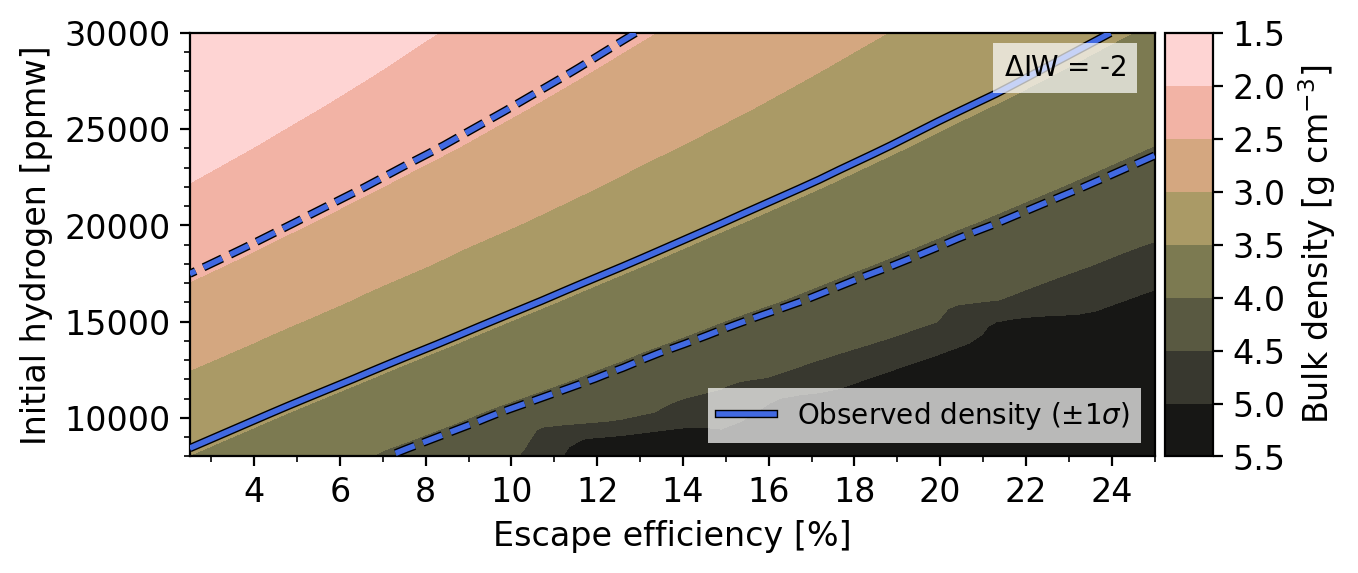

data/scratch/l98d_habrok5/


In [43]:
# -----------
# Reset
plt.close("all")
minz, maxz = None, None
xmult, ymult, zmult = 1.0, 1.0, 1.0
ztruth = None
zflip = False
extend = "neither"
title = ""
fmt_cbar = "%g"
control = {}
marker_s = 220
annotate = ""
xmajor, xminor = None, None
ymajor, yminor = None, None
outpath = "output/s2d_recent.pdf"

# -----------
# Variables

# x = "outgas.fO2_shift_IW";  x_lbl = "log$_{10}$ (fO$_{2}$ / IW)"; xscale="linear"
# x = "delivery.elements.H_ppmw";   x_lbl = "Hydrogen [ppmw]"; xscale="linear"
x = "escape.zephyrus.efficiency";  x_lbl = "Escape efficiency [%]"; xscale="linear"; xmult=100;  xmajor=2; xminor=1

# y = "struct.corefrac";   y_lbl = "Core radius [%]"; yscale="linear"; ymult=100
y = "delivery.elements.H_ppmw";   y_lbl = "Initial hydrogen [ppmw]"; yscale="linear"; ymajor=5000; yminor=1000
# y = "orbit.dummy.H_tide";   y_lbl = "$H_{tide}$ [W kg$^{-1}$]"; yscale="symlog"

# control["delivery.elements.H_ppmw"] = 100.0
control["outgas.fO2_shift_IW"] = -2
# control["delivery.elements.SH_ratio"] = 6
# control["struct.mass_tot"] = 2.39


# z = "H2S_vmr"; z_lbl = r"H$_2$S VMR [%]"; zscale="linear"; fmt_cbar = "%.1f"; zmult=100.0
# z = "H2_vmr"; z_lbl = r"H$_2$ VMR [%]"; zscale="linear"; fmt_cbar = "%.1f"; zmult=100.0
# z = "R_xuv"; z_lbl = r"XUV radius [km]"; zscale="linear"; zmult=1e-3; fmt_cbar="%d"
z = "rho_obs"; z_lbl = r"Bulk density [g cm$^{-3}$]"; zscale="linear"; fmt_cbar = "%.1f";  minz=1.5; maxz=5.5; zmult=1e-3; ztruth=[3.45-1.00, 3.45, 3.45+0.59]; truth_lbl=r"Observed density ($\pm1\sigma$)"; zflip=True
# z = "R_int"; z_lbl = r"Interior radius [$10^6$ m]"; zscale="linear"; fmt_cbar = "%.1f"; zmult=1e-6
# z = "P_surf"; z_lbl = "Surface pressure [bar]"; zscale="linear"; fmt_cbar = "%.1f"
# z = "T_surf"; z_lbl = "Surface temp. [K]"; zscale="linear"; fmt_cbar = "%d"; minz=1600; maxz=1850
# z = "Phi_global"; z_lbl = "Mantle melt [%]"; zscale="linear"; zmult=100; fmt_cbar="%.0f"; minz=10; maxz=50#; extend='min'
# z = "RF_radius"; z_lbl = "RF radius [%]"; zscale="linear"; zmult=100; fmt_cbar="%.0f"; minz=50; maxz=100#; extend='min'
# z = "Time"; z_lbl = "Time [Myr]"; zmult=1e-6; zscale="linear"; fmt_cbar="%.0f"; maxz=100; minz=0; extend='max'
# z = "F_tidal"; z_lbl = r"Tidal heat flux [W m$^{-2}$]"; zscale="linear"; fmt_cbar="%.0f"; minz=0
# z = "F_atm"; z_lbl = r"Net heat flux [W m$^{-2}$]"; zscale="linear"; fmt_cbar="%.0f"; minz=0
# z = "transit_depth"; z_lbl = r"Transit depth [ppm]"; zscale="linear"; zmult=1e6; fmt_cbar="%d"
# z = "contrast_ratio"; z_lbl = r"Contrast ratio [ppm]"; zscale="linear"; zmult=1e6; fmt_cbar="%.1f"
# z = "bond_albedo"; z_lbl = r"Bond albedo [%]"; zscale="linear"; zmult=100; fmt_cbar="%.1f"; minz=0#; maxz=10

# -----------
# Make plot
figsize       = (6,2.5)
plot_controls = False
plot_casenums = False
plot_scatter  = False
plot_grid     = False
hatch_solid   = False
figscale      = 1.1
norm_lev      = 9
cmap          = cm.turku_r# cm.vik
show_cbar     = True
interp        = 'contour'

outpath       = "output/%s-%s.pdf"%(pgrid_dir.split("/")[-2],z)
# x_lbl         = ""
annotate      = r"$\Delta$IW = %d"%control["outgas.fO2_shift_IW"]

fig,ax = make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, title=title, plot_grid=plot_grid,
         plot_scatter=plot_scatter,plot_casenums=plot_casenums, plot_controls=plot_controls,
         xscale=xscale, xmult=xmult, xmajor=xmajor, xminor=xminor,
         yscale=yscale, ymult=ymult, ymajor=ymajor, yminor=yminor,
         zscale=zscale, zmult=zmult, minz=minz, maxz=maxz, ztruth=ztruth, truth_lbl=truth_lbl, zflip=zflip,
         show_cbar=show_cbar, fmt_cbar=fmt_cbar, marker_s=marker_s, extend=extend,
         interp=interp, hatch_solid=hatch_solid, norm_lev=norm_lev, cmap=cmap,
         figscale=figscale, figsize=figsize, annotate=annotate
         )

fig.savefig(outpath, bbox_inches='tight')
plt.show()

print(pgrid_dir)